In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- SETUP DA SIMULAÇÃO ---
np.random.seed(10)
n_samples = 3000

# 1. Sistema Desconhecido (Planta IIR)
# H(z) = (0.5) / (1 - 0.6z^-1)
# Um sistema de 1ª ordem simples para facilitar a visualização da sensitividade
b_true = np.array([0.5])
a_true_vals = np.array([0.6]) # No vetor w: [-a1]

zeros_order = len(b_true) - 1
poles_order = len(a_true_vals)

# 2. Gerar Sinais
x = np.random.randn(n_samples)
d_clean = signal.lfilter(b_true, [1, -a_true_vals[0]], x)
# Adicionando ruído (Output Error lida bem com isso)
d = d_clean + 0.05 * np.random.randn(n_samples)

In [3]:
# --- INICIALIZAÇÃO DO FILTRO ---
# O Gauss-Newton baseado em gradiente é sensível ao step_size.
# Se o erro "explodir", diminua o step_size.
gn_grad = pdf.GaussNewtonGradient(
    zeros_order=zeros_order,
    poles_order=poles_order,
    step_size=0.005 
)

# --- EXECUÇÃO ---
result = gn_grad.optimize(
    input_signal=x, 
    desired_signal=d, 
    verbose=True, 
    return_internal_states=True
)

[GaussNewtonGradient] Completed in 74.04 ms


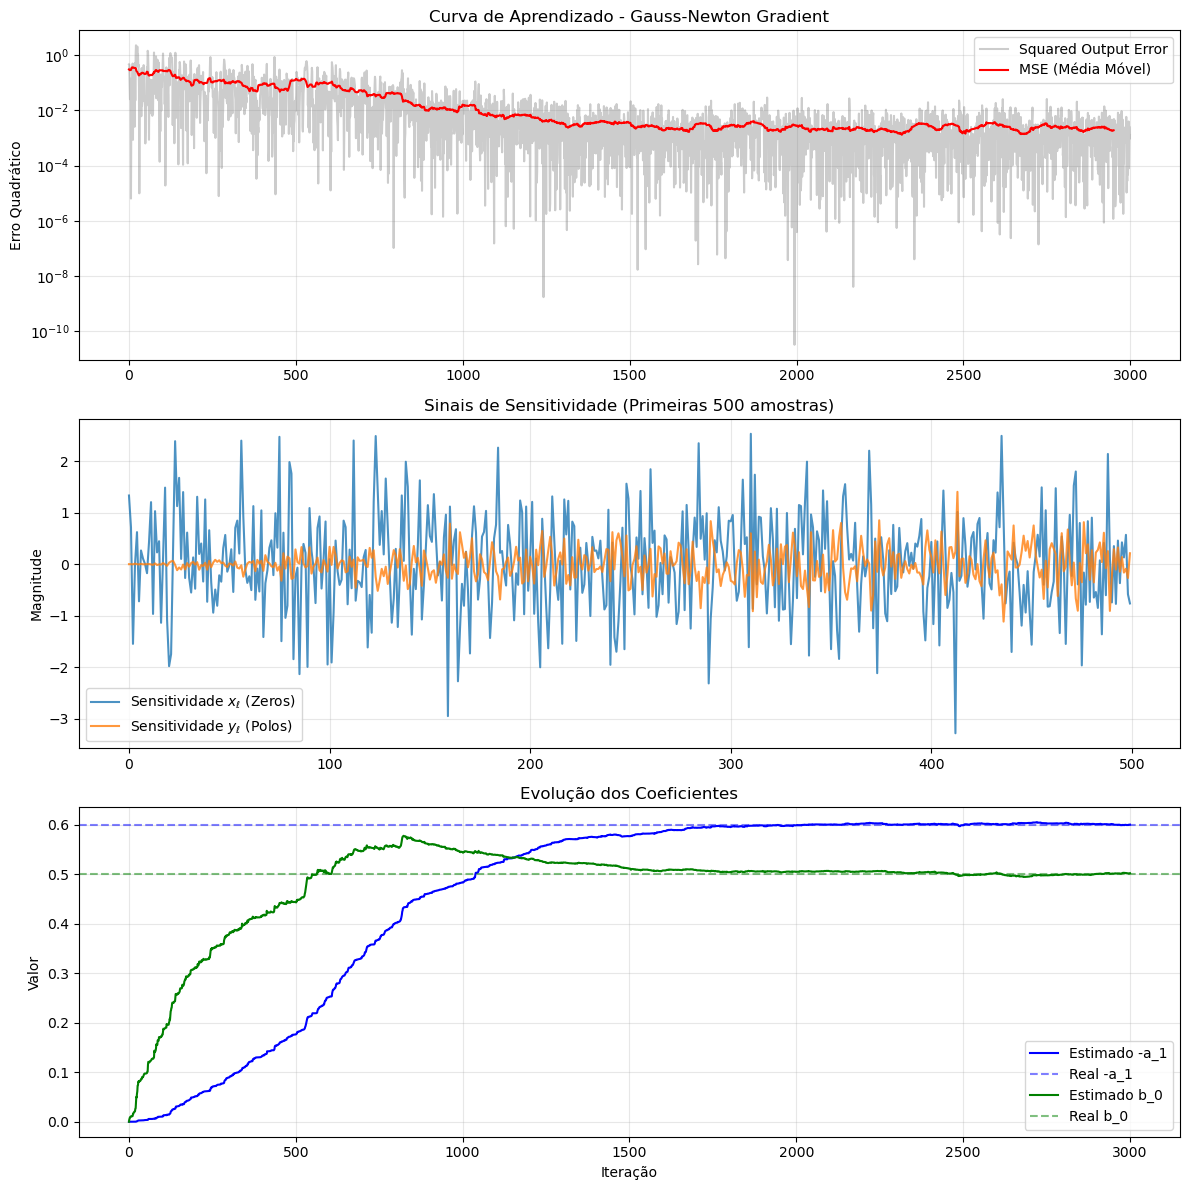

Final w: [0.59989371 0.50178209]


In [4]:
# --- VISUALIZAÇÃO ---
plt.figure(figsize=(12, 12))

# 1. Erro de Saída (MSE)
plt.subplot(3, 1, 1)
plt.plot(result.errors**2, label='Squared Output Error', alpha=0.4, color='gray')
# Média móvel para ver a tendência
plt.plot(np.convolve(result.errors**2, np.ones(50)/50, mode='valid'), label='MSE (Média Móvel)', color='red')
plt.title('Curva de Aprendizado - Gauss-Newton Gradient')
plt.yscale('log')
plt.ylabel('Erro Quadrático')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Sinais de Sensitividade
# Estes sinais representam as derivadas parciais do erro em relação aos pesos
plt.subplot(3, 1, 2)
plt.plot(result.extra["x_sensitivity"][:500], label=r'Sensitividade $x_{\ell}$ (Zeros)', alpha=0.8)
plt.plot(result.extra["y_sensitivity"][:500], label=r'Sensitividade $y_{\ell}$ (Polos)', alpha=0.8)
plt.title('Sinais de Sensitividade (Primeiras 500 amostras)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Evolução dos Pesos
plt.subplot(3, 1, 3)
w_history = np.array(result.coefficients)
plt.plot(w_history[:, 0], label='Estimado -a_1', color='blue')
plt.axhline(y=a_true_vals[0], color='blue', linestyle='--', alpha=0.5, label='Real -a_1')
plt.plot(w_history[:, 1], label='Estimado b_0', color='green')
plt.axhline(y=b_true[0], color='green', linestyle='--', alpha=0.5, label='Real b_0')
plt.title('Evolução dos Coeficientes')
plt.ylabel('Valor')
plt.xlabel('Iteração')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final w: {gn_grad.w}")